# Préparation des données pour la classification d'images de radiographie pulmonaire

Dans ce notebook, nous allons préparer les données pour notre projet de classification d'images médicales, en particulier des radiographies pulmonaires normales et avec pneumonie.


# 📓 Notebook 1 – ÉTAPE 1 : Charger les images NORMAL et PNEUMONIA                                                                                                                                             
📌 Objectif de cette étape  

🔍 Vérifier combien d’images sont présentes de chest_Xray, pour évaluer l’équilibre des classes (NORMAL vs PNEUMONIA) dans chaque split (train, val, test).

# 1.Imports et définition des chemins


In [13]:
import os
from pathlib import Path
import random
import shutil
from PIL import Image
import matplotlib.pyplot as plt

# Chemin vers le dossier d'origine
original_dir = Path("chest_Xray")

# Dictionnaire pour stocker les images
all_images = {
    "NORMAL": [],
    "PNEUMONIA": []
}

# Parcours tous les sous-dossiers (train, val, test)
for split in ["train", "val", "test"]:
    for cls in ["NORMAL", "PNEUMONIA"]:
        folder = original_dir / split / cls
        images = list(folder.glob("*"))
        all_images[cls].extend(images)

# Afficher le total brut par classe
for cls in ["NORMAL", "PNEUMONIA"]:
    print(f"{cls}: {len(all_images[cls])} images")


In [23]:
# Dictionnaire pour stocker les images
all_images = {
    "NORMAL": [],
    "PNEUMONIA": []
}

# Parcours tous les sous-dossiers (train, val, test)
for split in ["train", "val", "test"]:
    for cls in ["NORMAL", "PNEUMONIA"]:
        folder = original_dir / split / cls
        images = list(folder.glob("*"))
        all_images[cls].extend(images)

# Afficher le total brut par classe
for cls in ["NORMAL", "PNEUMONIA"]:
    print(f"{cls}: {len(all_images[cls])} images")


NORMAL: 1583 images
PNEUMONIA: 4275 images


On voit clairement que nous avons plus de scanners de pneumonies que de scanners avec des poumons sains. Il faut rééquilibrer les scanners sans pneumonie.

# 🧾 ÉTAPE 2 : Data Augmentation pour NORMAL
🎯 Objectif :

On a 1585 images NORMAL

On veut atteindre 3500

Il faut donc générer 1915 images augmentées



# 📦 Étape 2.1 — Créer la fonction d’augmentation avec les types associés

Comme on ne peut pas "inventer" de nouvelles vraies images, on utilise la Data Augmentation :
Cela consiste à appliquer des transformations simples à des images existantes pour en créer de nouvelles variantes réalistes.

🧰 Voici les types d’augmentations qu’on utilise :

flip :	Miroir horizontal (image retournée gauche ↔ droite)  

rotate10	: Rotation de l'image de +10°  

rotate-10 :	Rotation de l'image de -10°  

zoom	: On découpe une région centrale (90%) puis on la redimensionne à la taille originale (effet zoom)  

shift : 	On décale l'image vers la droite et le bas  

brightness :	On augmente la luminosité (effet éclaircissement)



In [24]:
from pathlib import Path
from PIL import Image, ImageEnhance
import random

def augment_image(image: Image.Image, aug_type: str) -> Image.Image:
    if aug_type == 'flip':
        return image.transpose(Image.FLIP_LEFT_RIGHT)
    elif aug_type == 'rotate10':
        return image.rotate(10)
    elif aug_type == 'rotate-10':
        return image.rotate(-10)
    elif aug_type == 'zoom':
        w, h = image.size
        crop = image.crop((w*0.1, h*0.1, w*0.9, h*0.9))  # zoom center
        return crop.resize((w, h))
    elif aug_type == 'shift':
        return image.transform(image.size, Image.AFFINE, (1, 0, 10, 0, 1, 10))
    elif aug_type == 'brightness':
        enhancer = ImageEnhance.Brightness(image)
        return enhancer.enhance(1.5)
    else:
        return image

# Dossier de sauvegarde
augmented_normal_dir = Path("augmented/NORMAL")
augmented_normal_dir.mkdir(parents=True, exist_ok=True)

# Liste des images originales
normal_images = [img for img in all_images["NORMAL"] if img.suffix.lower() in [".jpg", ".jpeg", ".png"]]
random.shuffle(normal_images)

aug_types = ['flip', 'rotate10', 'rotate-10', 'zoom', 'shift', 'brightness']
needed = 3500 - len(normal_images)
generated = 0
idx = 0

while generated < needed:
    img_path = normal_images[idx % len(normal_images)]
    try:
        img = Image.open(img_path).convert("RGB")
        aug_type = random.choice(aug_types)
        aug_img = augment_image(img, aug_type)
        save_path = augmented_normal_dir / f"aug_{generated}_{aug_type}_{img_path.name}"
        aug_img.save(save_path)
        generated += 1
    except Exception as e:
        print(f"❌ Erreur avec {img_path.name} : {e}")
    idx += 1

print(f"✅ {generated} images augmentées créées dans {augmented_normal_dir}")


✅ 1917 images augmentées créées dans augmented/NORMAL


# 📦 Étape 2.2 — Préparer les 3500 images de chaque classe  

NORMAL : 1585 originales + 1915 augmentées = 3500

PNEUMONIA : on prend un échantillon aléatoire de 3500 images

In [29]:
# On rassemble toutes les images NORMAL (originales + augmentées)
normal_src = Path("augmented/NORMAL")
normal_imgs = list(normal_src.glob("*"))
# On ajoute les originales si tu veux les garder aussi dans le split final
normal_imgs += [img for img in all_images["NORMAL"] if img.suffix.lower() in [".jpg", ".jpeg", ".png"]]
normal_imgs = normal_imgs[:3500]  # On s'arrête à 3500

# Pour PNEUMONIA : on prend 3500 images au hasard dans all_images["PNEUMONIA"]
pneumonia_imgs = [img for img in all_images["PNEUMONIA"] if img.suffix.lower() in [".jpg", ".jpeg", ".png"]]
random.shuffle(pneumonia_imgs)
pneumonia_imgs = pneumonia_imgs[:3500]


# 🧩 Étape 3 : Création du dataset équilibré dataset/train, dataset/val, dataset/test    
  
  🎯 Objectif :
Répartir 3 500 images de chaque classe (soit 7 000 images au total) comme suit :  

| Split | Pourcentage | Normal | Pneumonia | Total |
| ----- | ----------- | ------ | --------- | ----- |
| Train | 70%         | 2 450  | 2 450     | 4 900 |
| Val   | 15%         | 525    | 525       | 1 050 |
| Test  | 15%         | 525    | 525       | 1 050 |



In [32]:
import shutil

target_root = Path("dataset")
splits = ["train", "val", "test"]
classes = ["NORMAL", "PNEUMONIA"]

# Créer les dossiers si besoin
for split in splits:
    for cls in classes:
        (target_root / split / cls).mkdir(parents=True, exist_ok=True)

def split_and_copy(img_list, cls_name):
    train_count = 2450
    val_count = 525
    test_count = 525

    random.shuffle(img_list)
    train_imgs = img_list[:train_count]
    val_imgs = img_list[train_count:train_count + val_count]
    test_imgs = img_list[train_count + val_count:train_count + val_count + test_count]

    for img in train_imgs:
        shutil.copy(img, target_root / "train" / cls_name / img.name)
    for img in val_imgs:
        shutil.copy(img, target_root / "val" / cls_name / img.name)
    for img in test_imgs:
        shutil.copy(img, target_root / "test" / cls_name / img.name)

split_and_copy(normal_imgs, "NORMAL")
split_and_copy(pneumonia_imgs, "PNEUMONIA")


In [34]:
from pathlib import Path

target_root = Path("dataset")
splits = ["train", "val", "test"]
classes = ["NORMAL", "PNEUMONIA"]

# Comptage
counts = {split: {cls: 0 for cls in classes} for split in splits}
for split in splits:
    for cls in classes:
        folder = target_root / split / cls
        counts[split][cls] = len(list(folder.glob("*")))

# Affichage du tableau
print("| Split | Pourcentage | Normal | Pneumonia | Total |")
print("|-------|-------------|--------|-----------|-------|")
total_all = 0
for split in splits:
    split_total = counts[split]["NORMAL"] + counts[split]["PNEUMONIA"]
    percent = 100 * split_total / 7000
    print(f"| {split.capitalize():5} | {percent:9.1f}% | {counts[split]['NORMAL']:6} | {counts[split]['PNEUMONIA']:9} | {split_total:5} |")
    total_all += split_total
print(f"| Total |   100.0%    | {sum(counts[s]['NORMAL'] for s in splits):6} | {sum(counts[s]['PNEUMONIA'] for s in splits):9} | {total_all:5} |")


| Split | Pourcentage | Normal | Pneumonia | Total |
|-------|-------------|--------|-----------|-------|
| Train |      70.0% |   2450 |      2450 |  4900 |
| Val   |      15.0% |    525 |       525 |  1050 |
| Test  |      15.0% |    525 |       525 |  1050 |
| Total |   100.0%    |   3500 |      3500 |  7000 |



# 📈 4. Affichage graphique avec Matplotlib



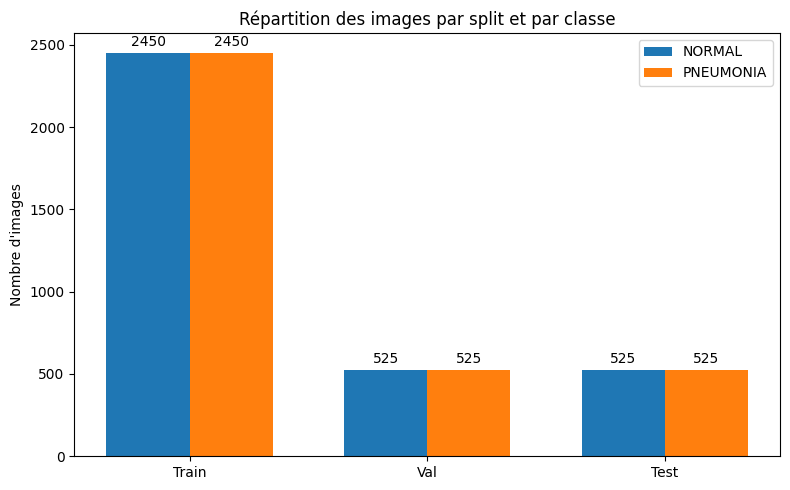

In [35]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["Train", "Val", "Test"]
normal_counts = [counts[split]["NORMAL"] for split in splits]
pneumonia_counts = [counts[split]["PNEUMONIA"] for split in splits]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, normal_counts, width, label='NORMAL')
rects2 = ax.bar(x + width/2, pneumonia_counts, width, label='PNEUMONIA')

ax.set_ylabel("Nombre d'images")
ax.set_title("Répartition des images par split et par classe")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),  # décalage vertical
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


# 🧾 Synthèse - Préparation des données (Notebook 1)
🔎 Synthèse de la préparation du dataset
1. Constat initial
Déséquilibre des classes :

1585 images NORMAL

4275 images PNEUMONIA

2. Data Augmentation
Objectif : Atteindre 3500 images NORMAL pour équilibrer avec PNEUMONIA.

Méthode : Génération de 1915 images augmentées à partir des images NORMAL originales (flip, rotations, zoom, shift, brightness, etc.).

Résultat :

1585 images originales + 1915 images augmentées = 3500 images NORMAL

3. Équilibrage de PNEUMONIA
Sélection : Échantillonnage aléatoire de 3500 images PNEUMONIA pour équilibrer avec NORMAL.

4. Split du dataset
Répartition :

Train : 70% (2450 images par classe)

Validation : 15% (525 images par classe)

Test : 15% (525 images par classe)

Total :

2450 + 525 + 525 = 3500 images par classe

7000 images au total

5. Vérification & Visualisation
Comptage : Le code vérifie le nombre d’images dans chaque split et chaque classe.

Affichage graphique : Un graphique à barres (Matplotlib) montre la répartition parfaite 70/15/15 pour chaque classe.

Tableau attendu :
Split	Pourcentage	Normal	Pneumonia	Total
Train	70%	2450	2450	4900
Val	15%	525	525	1050
Test	15%	525	525	1050
Total	100%	3500	3500	7000
Le graphique confirme l’équilibre parfait entre les classes et les splits.

Conclusion
Le dataset est désormais équilibré et prêt à l’emploi pour l’entraînement d’un modèle IA fiable en classification d’images pulmonaires.

Toutes les étapes sont reproductibles et vérifiables (comptage + graphique).

